In [1]:
import os

model_names = sorted(os.listdir('./Tables'))
model_names = [name.split('.xlsx')[0] for name in model_names]

In [2]:
model_sizes={
    'MultiModel-A': 23 + 9 + 260,
    'MultiModel-A-Comb': 23 + 9 + 260,
    'MultiModel-B': 23 + 4 + 4,
    'MultiModel-B-Comb': 23 + 4 + 4,
    'Mask2Former-Fp32': 190,
    'O2SFormer-Fp32': 125,
    'Resa-Fp16': 45,
    'Resa-Fp32': 90,
    'SegFormer-Fp16-trt': 21,
    'SegFormer-Fp16': 9,
    'SegFormer-Fp32-trt': 21,
    'SegFormer-Fp32': 16,
    'TwinLiteNet-Fp16-trt': 4,
    'TwinLiteNet-Fp16': 1,
    'TwinLiteNet-Fp32-trt': 7,
    'TwinLiteNet-Fp32': 2,
    'UFLDv2-Fp16-trt': 260,
    'UFLDv2-Fp32-trt': 530,
    'UFLDv2-Fp32': 385,
    'UperNet-Fp16': 120,
    'UperNet-Fp32': 240,
    'YoloV5s-Fp16-trt': 30,
    'YoloV5s-Fp16': 15,
    'YoloV5s-Fp32': 30,
    'YoloV7-Fp16': 75,
    'YoloV7-Fp32': 150,
    'YoloV8s-Fp16-trt': 64,
    'YoloV8s-Fp16': 23,
    'YoloV8s-Fp32-trt': 66,
    'YoloV8s-Fp32': 45,
    'Yolop-Fp16-trt': 40,
    'Yolop-Fp16': 16,
    'Yolop-Fp32-trt': 56,
    'Yolop-Fp32': 32,
    'YolopV2-Fp16-trt': 113,
}

In [3]:
max_size = model_sizes[max(model_sizes, key=model_sizes.get)]

In [4]:
yolops = [
'YolopV2-Fp16-trt',
'MultiModel-A',
'MultiModel-B',
'MultiModel-A-Comb',
'MultiModel-B-Comb'
]

twin_lite_net = [
]

In [5]:
import pandas as pd
models = {}
for model in model_names:
    models[model] = {}
    # models[model]['model'] = model
    table_o = pd.read_excel('./Tables/'+model+'.xlsx', sheet_name='Results', header = [0,1])
    mode_obj = 1 if 'Object detection' in table_o else 0
    mode_da = 1 if 'Drivable area' in table_o else 0
    mode_l = 1 if 'Lane marking' in table_o else 0
    if mode_obj:
        table_obj = table_o[['Unnamed: 0_level_0','Object detection']].dropna()
        models[model]['Object detection'] = {}
        models[model]['Object detection']['model'] = model
        models[model]['Object detection']['fps'] = table_obj[('Object detection', 'FPS')].iloc[0]
        models[model]['Object detection']['AP@50'] = table_obj[('Object detection', 'AP@50')].iloc[0]
        models[model]['Object detection']['AP@75'] = table_obj[('Object detection', 'AP@75')].iloc[0]
        models[model]['Object detection']['model_size'] = model_sizes[model]
    if mode_da:
        table_da = table_o[['Unnamed: 0_level_0','Drivable area']].dropna()
        table_da
        models[model]['Drivable area'] = {}
        models[model]['Drivable area']['model'] = model
        models[model]['Drivable area']['fps'] = table_da[('Drivable area', 'FPS')].iloc[0]
        models[model]['Drivable area']['iou'] = table_da[('Drivable area', 'IoU')].iloc[0]
        models[model]['Drivable area']['model_size'] = model_sizes[model]
    if mode_l:
        table_l = table_o[['Unnamed: 0_level_0','Lane marking']].dropna()
        models[model]['Lane marking'] = {}
        models[model]['Lane marking']['model'] = model
        models[model]['Lane marking']['fps'] = table_l[('Lane marking', 'FPS')].iloc[0]
        models[model]['Lane marking']['iou'] = table_l[('Lane marking', 'IoU')].iloc[0]
        models[model]['Lane marking']['model_size'] = model_sizes[model]
        
            

In [6]:
drivable_results_yolop = []
drivable_results_twin = []
drivable_results_single = []
lane_results_yolop = []
lane_results_twin = []
lane_results_single = []
obj_results_yolop = []
obj_results_single = []
for model in models:
    drivable_results = None
    lane_results = None
    obj_results = None
    if 'Drivable area' in models[model]:
        drivable_results = models[model]['Drivable area']
    if 'Lane marking' in models[model]:
        lane_results = models[model]['Lane marking']
    if 'Object detection' in models[model]:
        obj_results = models[model]['Object detection']
    print(model)
    if model in yolops:
        print(model)
        drivable_results_yolop.append(drivable_results)
        lane_results_yolop.append(lane_results)
        obj_results_yolop.append(obj_results)
    elif model in twin_lite_net:
        drivable_results_twin.append(drivable_results)
        lane_results_twin.append(lane_results)
    else:
        if not(drivable_results is None):
            drivable_results_single.append(drivable_results)
        if not(lane_results is None):
            lane_results_single.append(lane_results)
        if not(obj_results is None):
            obj_results_single.append(obj_results)
            

MultiModel-A-Comb
MultiModel-A-Comb
MultiModel-A
MultiModel-A
MultiModel-B-Comb
MultiModel-B-Comb
MultiModel-B
MultiModel-B
YolopV2-Fp16-trt
YolopV2-Fp16-trt


In [7]:
import copy
import matplotlib.pyplot as plt
import matplotlib
from adjustText import adjust_text

def generate_graph(list_dict, max_size, save_name, ap = 'AP@50', y_top = None, y_bottom = None):
    max = 5000
    factor = 5000/max_size
    l_dict = copy.deepcopy(list_dict)
    if 'iou' in l_dict[0]:
        mode_iou = 1
        axis_label = 'IoU'
    else:
        mode_iou = 0
        axis_label = ap
    n_colors = len(l_dict)
    cmap = matplotlib.colormaps.get_cmap('rainbow')
    color_list = [cmap(x/(n_colors-1))[:3] for x in range(0,n_colors)]
    for idx, dict1 in enumerate(l_dict):
        dict1['color'] = color_list[idx]
        dict1['model_size'] = int(dict1['model_size'] * factor)
        if mode_iou:
            dict1['iou'] = dict1['iou'] * 100
        else:
            dict1['AP@50'] = dict1['AP@50'] * 100
            dict1['AP@75'] = dict1['AP@75'] * 100
    df = pd.DataFrame(l_dict)
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(data=df,
                         x="fps",
                         y="iou" if mode_iou else ap,
                         c="color",
                         s="model_size",
                         marker = "o"
                     )
    ax.set_xlabel("Inference speed (FPS)", fontsize=14)
    ax.set_ylabel(axis_label+ " (%)", fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    ax.grid(True)
    if not(y_top is None) and not(y_bottom is None):
        ax.set_ylim(bottom=y_bottom, top=y_top)
    elif not(y_top is None):
        ax.set_ylim(top=y_top)
    elif not(y_bottom is None):
        ax.set_ylim(bottom=y_bottom)
    x = df['fps'].tolist()
    y = df["iou" if mode_iou else ap].tolist()
    text = df['model'].tolist()
    texts = [plt.text(x[i], y[i], text[i], size=11) for i in range(len(x))]
    adjust_text(texts, 
                # arrowprops=dict(arrowstyle='-', color='red')
               )
    # texts[5].set_visible(False)
    # texts[4].set_visible(False)
    # plt.text(18.279344511236687, 57.01394605670178, 'YoloV8s-Fp16-trt', size=11)
    # plt.text(32, 53.6, 'YoloV7-Fp32', size=11)
    for index, row in df.iterrows():
        
        # ax.annotate(text=row["model"], # note: in some versions of Matplotlib, this may need to be "text" rather than "s"
        #             xy=(row["fps"]+0.001, row["iou"]+teste),
        #             size=12,
        #             )
        ax.scatter(data=df,
                   x=df["fps"][index],
                   y=df["iou" if mode_iou else ap][index],
                   c=[[0,0,0]],
                   s=0.1
                   )
    plt.savefig(save_name)
    

In [8]:
drivable_results_yolop

[{'model': 'MultiModel-A-Comb',
  'fps': 25.92797971484952,
  'iou': 0.4564140168445508,
  'model_size': 292},
 {'model': 'MultiModel-A',
  'fps': 37.73447195309238,
  'iou': 0.4564140168445508,
  'model_size': 292},
 {'model': 'MultiModel-B-Comb',
  'fps': 46.98485848629608,
  'iou': 0.801436604303401,
  'model_size': 31},
 {'model': 'MultiModel-B',
  'fps': 179.29197646915,
  'iou': 0.801436604303401,
  'model_size': 31},
 {'model': 'YolopV2-Fp16-trt',
  'fps': 92.2245270929932,
  'iou': 0.826076798337659,
  'model_size': 113}]

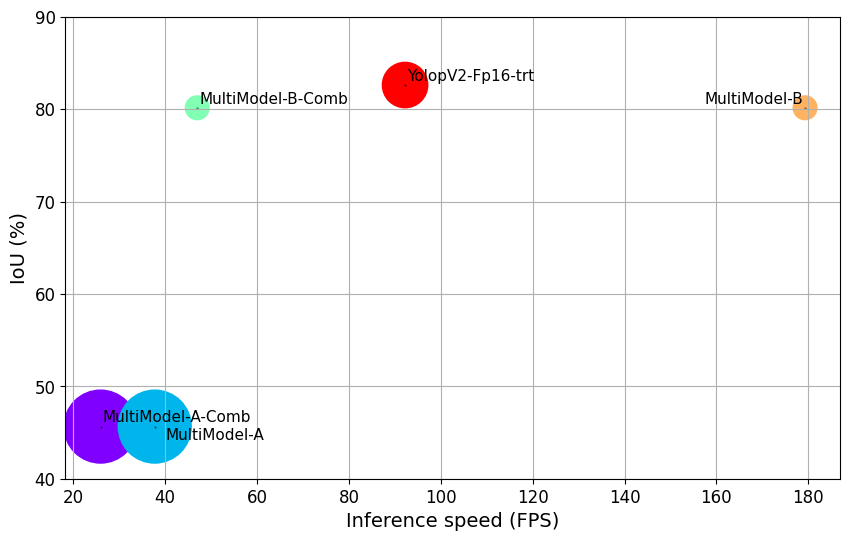

In [9]:
generate_graph(drivable_results_yolop, max_size, 'Drivable_multi.pdf', y_bottom= 40, y_top=90)

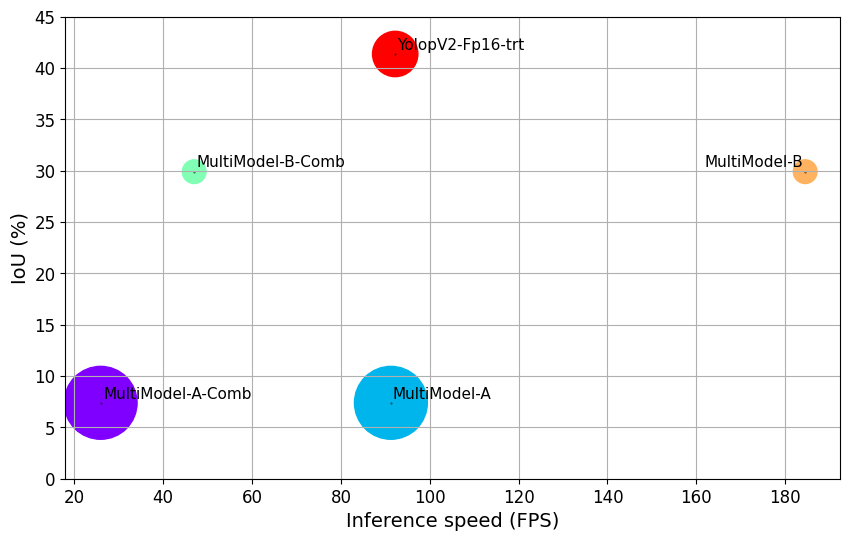

In [10]:
generate_graph(lane_results_yolop, max_size, 'Lane_multi.pdf', y_bottom= 0, y_top=45)

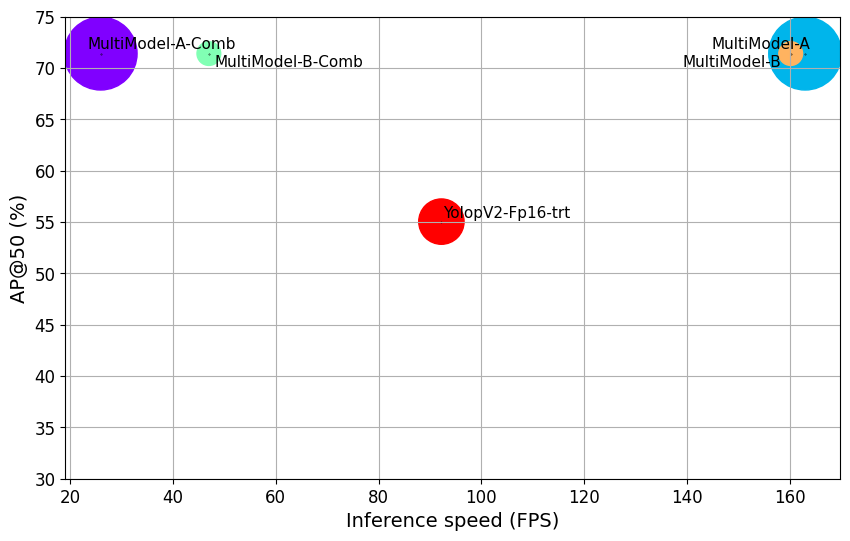

In [11]:
generate_graph(obj_results_yolop, max_size, 'Object-AP50_multi.pdf', ap = 'AP@50', y_bottom= 30, y_top=75)

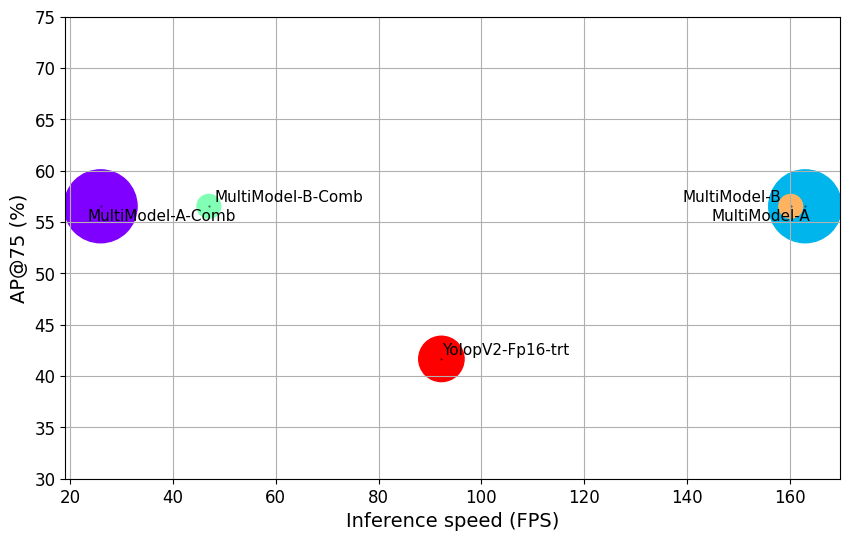

In [12]:
generate_graph(obj_results_yolop, max_size, 'Object-AP75_multi.pdf', ap = 'AP@75', y_bottom= 30, y_top=75)